# Remarks

* Data normalization
    * Mobilenet expects data from -1 to 1
        * Normalize Input Data or Include in Model
        * TFLite Conversion must fit according to decision
    * Ground Truth Data: for better inspection Data multiplied by 80. Undo the change in the Data Input Pipeline
* Overview in Tutorials:
    * tf.function
* Idea

# Libraries

In [34]:
#!for a in /sys/bus/pci/devices/*; do echo 0 | sudo tee -a $a/numa_node; done

import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import os
import time
from datetime import datetime
import sys
import matplotlib.pyplot as plt
import argparse
import yaml

import DataProcessing.dataset as dataset
import DataProcessing.model_files as model_files
import Nets.backbones as backbones
import Nets.features as features
import Nets.losses as losses
import Nets.metrics as metrics
import Nets.visualize as visualize
import Nets.tools as tools

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

#np.set_printoptions(threshold=sys.maxsize)

# Parser

In [35]:
parser = argparse.ArgumentParser()

parser.add_argument('--model', type=str, required=False, default=None)
parser.add_argument('--data', type=str, required=False, default=None)

parser.add_argument('--bs', type=int, required=False, default=None)
parser.add_argument('--idx', type=int, required=False, default=None)
parser.add_argument('--epoch', type=int, required=False, default=None)
parser.add_argument('--noise', type=float, required=False, default=None)

parser.add_argument('--train_model', action='store_true', default=False)
parser.add_argument('--cache', action='store_true', default=False)
parser.add_argument('--save', action='store_true', default=False)
parser.add_argument('--sigmoid', action='store_true', default=False)
parser.add_argument('--focal', action='store_true', default=False)

parser.add_argument('--beta_upper', type=float, required=False, default=None)
parser.add_argument('--gamma', type=float, required=False, default=None)
parser.add_argument('--alpha', type=float, required=False, default=None)

file_name = None
try:
    file_name = __file__
except:
    print("Jupyter Notebook")

if file_name is None:
    args = parser.parse_args("")
    args.train_model = True
    args.cache = True
    #args.save = True
    args.save = True
    args.sigmoid = False
    args.focal = True
else:
    args = parser.parse_args()

Jupyter Notebook


# Options

In [36]:
# Generall Parameters
TRAIN_MODEL = True  #args.train_model
SEED = None

# LOSS
weighted_multi_label_sigmoid_edge_loss = args.sigmoid
# focal_loss = args.focal
focal_loss = True

beta_upper = 0.5 if args.beta_upper is None else args.beta_upper
beta_lower = 1.0 - beta_upper
gamma = 2.0 if args.gamma is None else args.gamma
alpha = 2.0 if args.alpha is None else args.alpha
class_weighted = True
weighted_beta = True

config_path = os.path.join(os.getcwd(), 'configs')
model_config_path = os.path.join(config_path, 'model.yaml')

with open(model_config_path, 'r') as file:
    model_cfg = yaml.safe_load(file)

# Load Dataset, Preprocess Images and Dataset

In [37]:
tf.random.set_seed(SEED)

DP = dataset.DataProcessing(model_cfg["INPUT_SHAPE"], model_cfg["OUTPUT_SHAPE"], config_path)
DP.path_definitions()

MF = model_files.ModelFiles()
MF.path_definitions(model_cfg["NAME"], DP.dataset["NAME"], make_dirs=True)
MF.clean_model_directories(model_cfg["CALLBACKS"]["DEL_OLD_CKPT"], model_cfg["CALLBACKS"]["DEL_OLD_TB"])

if TRAIN_MODEL:
    rng = tf.random.Generator.from_seed(123, alg='philox')

    train_ds, img_count_train = DP.load_dataset(DP.key.train)
    train_ds = DP.dataset_processing(train_ds, DP.key.train, shuffle=True, prefetch=True,
                                     img_count=int(img_count_train / 2), rng=rng, prior=True)

test_ds, img_count_test = DP.load_dataset(DP.key.test)
test_ds = DP.dataset_processing(test_ds, DP.key.test, shuffle=False, prefetch=False, img_count=img_count_test,
                                prior=True)

139
The TRAIN DS contains 140 images.
139
The TEST DS contains 140 images.


# Model

In [38]:
if weighted_multi_label_sigmoid_edge_loss:
    loss = lambda y_true, y_pred: losses.weighted_multi_label_sigmoid_loss(y_true, y_pred, beta_lower=beta_lower,
                                                                           beta_upper=beta_upper,
                                                                           class_weighted=class_weighted)
elif focal_loss:
    loss = lambda y_true, y_pred: losses.focal_loss_edges(y_true, y_pred, gamma=gamma, alpha=alpha,
                                                          weighted_beta=weighted_beta, beta_lower=beta_lower,
                                                          beta_upper=beta_upper, class_weighted=class_weighted)
else:
    raise ValueError("either FocalLoss or WeightedMultiLabelSigmoidLoss must be True")


2022-10-31 13:51:36.976193: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


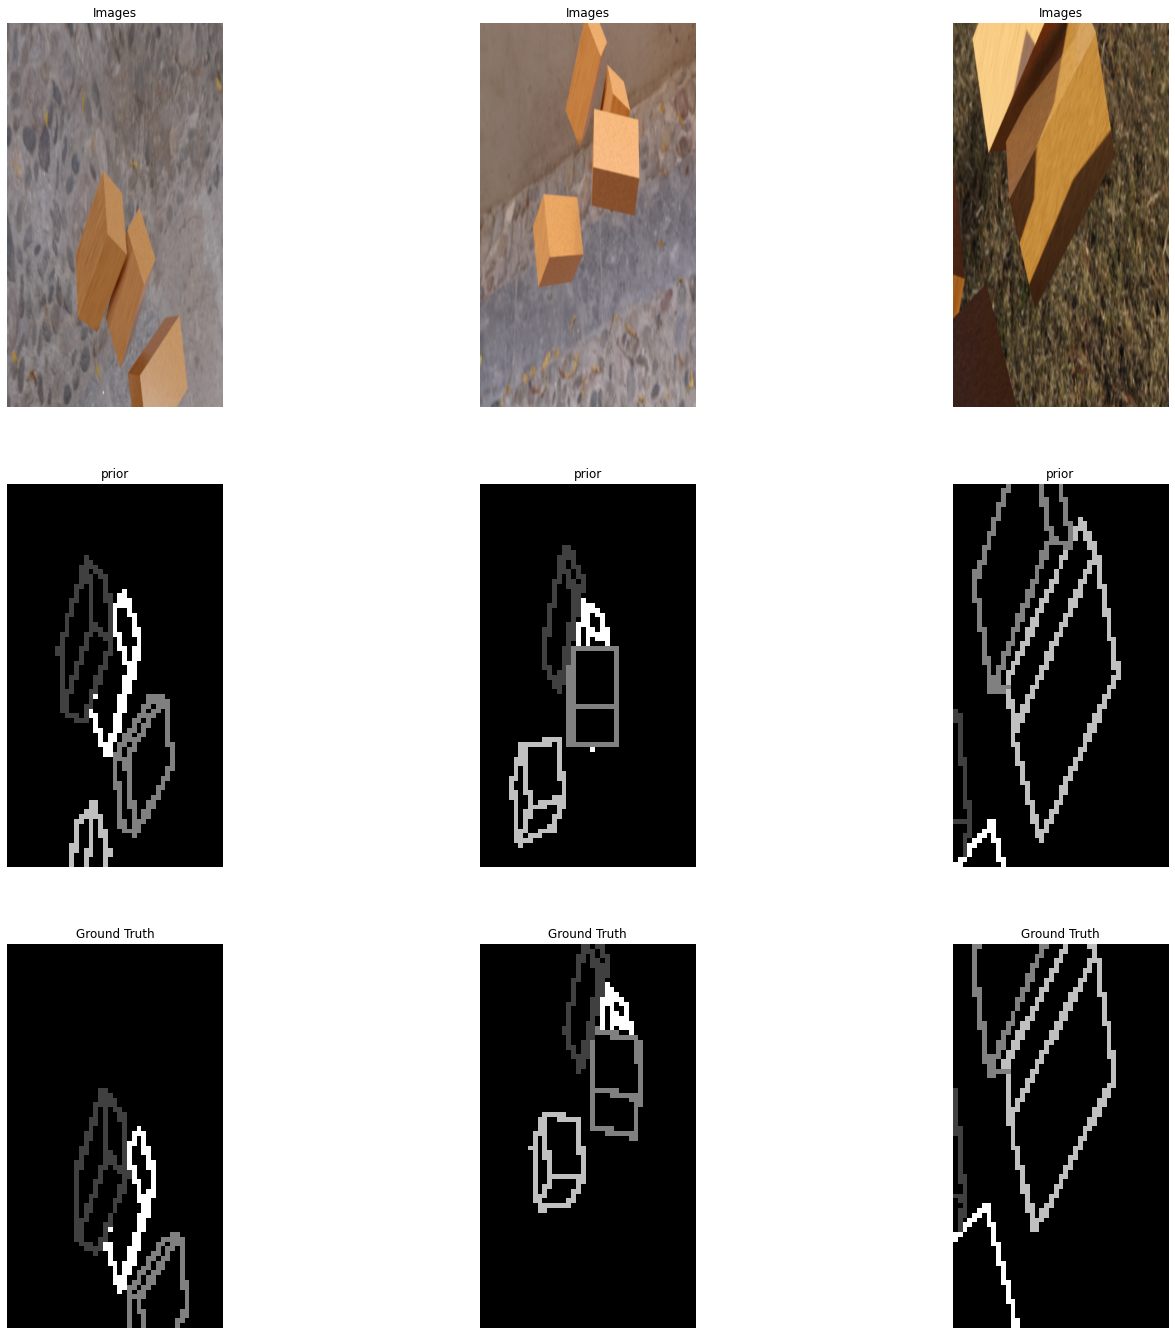

In [40]:
bs = 3
i = 0
for img, label in test_ds.take(1):
    img, label = img, label

    plt.figure(figsize=(3 * 8, 24))
    for i in range(bs):
        plt.subplot(3, bs, i + 1)
        plt.title("Images")
        plt.imshow(tf.keras.preprocessing.image.array_to_img(img[0][i, :, :, :]))
        plt.axis('off')

        plt.subplot(3, bs, bs + i + 1)
        plt.title("prior")
        plt.imshow(img[1][i, :, :, 0], cmap='gray', vmin=0, vmax=4)
        plt.axis('off')

        plt.subplot(3, bs, 2 * bs + i + 1)
        plt.title("Ground Truth")
        plt.imshow(label[i, :, :, 0], cmap='gray', vmin=0, vmax=4)
        plt.axis('off')

In [41]:
if TRAIN_MODEL:
    output_dims = model_cfg["OUTPUT_SHAPE"]

    # BACKBONE
    backbone, output_names = backbones.get_backbone(name=model_cfg["BACKBONE"]["NAME"],
                                                    weights=model_cfg["BACKBONE"]["WEIGHTS"],
                                                    height=model_cfg["INPUT_SHAPE"][0],
                                                    width=model_cfg["INPUT_SHAPE"][1],
                                                    alpha=model_cfg["BACKBONE"]["ALPHA"],
                                                    output_layer=model_cfg["BACKBONE"]["OUTPUT_IDS"],
                                                    trainable_idx=model_cfg["BACKBONE"]["TRAIN_IDX"])

    # prior edge map input
    input_model = tf.keras.Input(shape=(output_dims[0], output_dims[1], 1))
    x = tf.keras.layers.Conv2D(9, kernel_size=3, dilation_rate=1, padding="same", strides=1, use_bias=False)(
        input_model)

    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    x = tf.keras.layers.DepthwiseConv2D(kernel_size=5, dilation_rate=1, padding="same", strides=2, use_bias=False)(x)

    x = tf.keras.layers.BatchNormalization()(x)
    x_out = tf.keras.layers.ReLU(name="x_out")(x)

    # backbone output
    b = tf.keras.layers.Conv2D(9, kernel_size=3, dilation_rate=1, padding="same", strides=2, use_bias=False)(
        backbone.output[-1])
    b = tf.keras.layers.BatchNormalization()(b)
    b = tf.keras.layers.ReLU()(b)

    # Mix layers
    #concat:
    c = tf.keras.layers.Concatenate(axis=-1)([x_out, b])
    c = tf.keras.layers.Conv2D(9, kernel_size=3, dilation_rate=1, padding="same", strides=1, use_bias=False)(c)
    c = tf.keras.layers.BatchNormalization()(c)
    c = tf.keras.layers.ReLU()(c)
    c = tf.keras.layers.Conv2D(9, kernel_size=3, dilation_rate=1, padding="same", strides=1, use_bias=False)(c)
    c = tf.keras.layers.BatchNormalization()(c)
    c = tf.keras.layers.ReLU()(c)

    # mult. layers:
    mu = tf.keras.layers.Conv2D(16, kernel_size=3, dilation_rate=1, padding="same", strides=1, use_bias=False)(
        backbone.output[-1])
    mu = tf.keras.layers.BatchNormalization()(mu)
    mu = tf.keras.layers.ReLU()(mu)

    mu = tf.keras.layers.Conv2D(4, kernel_size=3, dilation_rate=1, padding="same", strides=2, use_bias=False)(mu)
    mu = tf.keras.layers.BatchNormalization()(mu)
    mu = tf.keras.layers.ReLU(name="out_mu")(mu)

    out = []
    for i in range(9):
        out.append(mu * c[:, :, :, i:i + 1])
    x = tf.keras.layers.Concatenate(axis=-1)(out)

    # Post Processing
    x = tf.keras.layers.DepthwiseConv2D(kernel_size=3, dilation_rate=1, padding="same", strides=2, use_bias=False)(x)

    x = tf.keras.layers.Conv2D(16, kernel_size=3, dilation_rate=1, padding="same", strides=1, use_bias=True)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    x = tf.keras.layers.Conv2D(16, kernel_size=3, dilation_rate=1, padding="same", strides=1, use_bias=True)(x)

    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    #x = tf.keras.layers.SeparableConv2D(32, kernel_size=3, dilation_rate=1, padding="same",
    #              strides=1, use_bias=True)(x)
    #x = tf.keras.layers.BatchNormalization()(x)
    #x = tf.keras.layers.ReLU()(x)
    #

    x = tf.image.resize(x, (output_dims[0], output_dims[1]))

    x = tf.keras.layers.Conv2D(16, kernel_size=3, dilation_rate=1, padding="same", strides=1, use_bias=True)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    #x = tf.keras.layers.ReLU()(x)

    #b1 = tf.keras.layers.Conv2D(4, kernel_size=3, dilation_rate=1, padding="same",
    #                      strides=1, use_bias=True)(backbone.output[0])
    #b1 = tf.keras.layers.BatchNormalization()(b1)
    #b1 = tf.keras.layers.ReLU()(b1)

    #b3 = tf.keras.layers.Conv2D(DP.num_classes, kernel_size=3, dilation_rate=1, padding="same",
    #                      strides=1, use_bias=True)(backbone.output[2])
    #b3 = tf.keras.layers.BatchNormalization()(b3)
    #b3 = tf.keras.layers.ReLU()(b3)

    # DASPP
    #daspp = features.DASPP_dilation(backbone.output[-1])

    # Decoder
    #decoded = features.decoder(daspp, backbone.output[-1], output_dims=output_dims, NUM_CLASSES=DP.num_classes,
    #                           num_side_filters=6)

    # SIDE FEATURES
    # TODO: Upsampling: Nearest NEIGHBOUR ?
    #upsample_side_1 = features.side_feature_SGED(backbone.output[0], output_dims=output_dims,
    #                                             num_classes=DP.num_classes, interpolation="bilinear", name="side1")
    #upsample_side_2 = features.side_feature_SGED(backbone.output[1], output_dims=output_dims,
    #                                             num_classes=DP.num_classes, interpolation="bilinear", name="side2")
    # upsample_side_3 = features.side_feature_SGED(backbone.output[2], output_dims=output_dims ,interpolation="bilinear", name="side3")

    # TODO: adaptive weight fusion ?
    # CONCATENATE
    #side_outputs = [upsample_side_1, upsample_side_2, decoded]

    # concat = features.shared_concatenation(side_outputs,NUM_CLASSES)
    # output = features.fused_classification(concat,NUM_CLASSES,name="output")

    #side_outputs = [x,b1]
    #side_outputs = [x,b3]

    #x1 = tf.keras.layers.Concatenate(axis=-1)(side_outputs)
    output = tf.keras.layers.Conv2D(DP.num_classes, kernel_size=3, dilation_rate=1, padding="same", strides=1,
                                    use_bias=True, name="output_ANN")(x)

    # output = features.shared_concatenation_fused_classification(side_outputs, DP.num_classes, name="output")
    model = tf.keras.Model(inputs=(backbone.input, input_model), outputs=(output, mu, x_out))

    # model.layers[-1]._name = "output"
    model.summary()


640
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 640, 360, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_15 (InputLayer)          [(None, 80, 45, 1)]  0           []                               
                                                                                                  
 tf.math.truediv_4 (TFOpLambda)  (None, 640, 360, 3)  0          ['input_14[0][0]']               
                                                                                                  
 conv2d_36 (Conv2D)             (None, 80, 45, 9)    81          ['input_15[0][0]']     

 tf.__operators__.getitem_39 (S  (None, 40, 23, 1)   0           ['re_lu_32[0][0]']               
 licingOpLambda)                                                                                  
                                                                                                  
 tf.__operators__.getitem_40 (S  (None, 40, 23, 1)   0           ['re_lu_32[0][0]']               
 licingOpLambda)                                                                                  
                                                                                                  
 tf.__operators__.getitem_41 (S  (None, 40, 23, 1)   0           ['re_lu_32[0][0]']               
 licingOpLambda)                                                                                  
                                                                                                  
 tf.__operators__.getitem_42 (S  (None, 40, 23, 1)   0           ['re_lu_32[0][0]']               
 licingOpL

 conv2d_44 (Conv2D)             (None, 80, 45, 16)   2320        ['tf.image.resize_4[0][0]']      
                                                                                                  
 batch_normalization_49 (BatchN  (None, 80, 45, 16)  64          ['conv2d_44[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 output (Conv2D)                (None, 80, 45, 4)    580         ['batch_normalization_49[0][0]'] 
                                                                                                  
Total params: 33,529
Trainable params: 31,751
Non-trainable params: 1,778
__________________________________________________________________________________________________


# Compile and Train Model

In [43]:
if TRAIN_MODEL:
    # learning rate schedule
    base_learning_rate = 0.0015
    # end_learning_rate = 0.0005
    end_learning_rate = 0.0001
    decay_step = np.ceil(img_count_train / DP.dataset[DP.key.train]["BATCH_SIZE"]) * model_cfg["EPOCHS"]
    lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(base_learning_rate, decay_steps=decay_step,
                                                                end_learning_rate=end_learning_rate, power=0.9)

    frequency = int(
        np.ceil(img_count_train / DP.dataset[DP.key.train]["BATCH_SIZE"]) * model_cfg["CALLBACKS"]["CKPT_FREQ"]) + 1

    logdir = os.path.join(MF.paths['TBLOGS'], datetime.now().strftime("%Y%m%d-%H%M%S"))
    callbacks = [tf.keras.callbacks.ModelCheckpoint(
        filepath=MF.paths["CKPT"] + "/ckpt-loss={val_loss:.2f}-epoch={epoch:.2f}-f1={val_f1:.4f}",
        save_weights_only=False, save_best_only=False, monitor="val_f1", verbose=1, save_freq='epoch', period=5),
        tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)]

    # compile model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), loss={"output": loss}, metrics={
        "output": [metrics.BinaryAccuracyEdges(threshold_prediction=0),
                   metrics.F1Edges(threshold_prediction=0, threshold_edge_width=0)]})

    history = model.fit(train_ds, epochs=model_cfg["EPOCHS"], validation_data=train_ds, callbacks=callbacks)


Epoch 1/40
47/47 [==============================] - 5s 62ms/step - loss: 64.9042 - output_loss: 64.9042 - output_accuracy_edges: 0.8935 - f1: 0.3051 - precision: 0.4954 - recall: 0.2211 - val_loss: 100.8533 - val_output_loss: 100.8533 - val_output_accuracy_edges: 0.8684 - val_f1: 0.3189 - val_precision: 0.3188 - val_recall: 0.3190
Epoch 2/40
47/47 [==============================] - 3s 54ms/step - loss: 62.7845 - output_loss: 62.7845 - output_accuracy_edges: 0.8943 - f1: 0.3107 - precision: 0.5353 - recall: 0.2197 - val_loss: 111.9726 - val_output_loss: 111.9726 - val_output_accuracy_edges: 0.8795 - val_f1: 0.1824 - val_precision: 0.2863 - val_recall: 0.1339
Epoch 3/40
47/47 [==============================] - 3s 54ms/step - loss: 60.8161 - output_loss: 60.8161 - output_accuracy_edges: 0.8952 - f1: 0.3035 - precision: 0.5363 - recall: 0.2120 - val_loss: 102.9951 - val_output_loss: 102.9951 - val_output_accuracy_edges: 0.8783 - val_f1: 0.2577 - val_precision: 0.3249 - val_recall: 0.2136
E

Epoch 21/40
47/47 [==============================] - 3s 59ms/step - loss: 47.4374 - output_loss: 47.4374 - output_accuracy_edges: 0.9078 - f1: 0.4750 - precision: 0.6080 - recall: 0.3901 - val_loss: 57.9131 - val_output_loss: 57.9131 - val_output_accuracy_edges: 0.9003 - val_f1: 0.4004 - val_precision: 0.5523 - val_recall: 0.3140
Epoch 22/40
47/47 [==============================] - 3s 57ms/step - loss: 47.1824 - output_loss: 47.1824 - output_accuracy_edges: 0.9079 - f1: 0.4817 - precision: 0.6080 - recall: 0.3990 - val_loss: 54.7376 - val_output_loss: 54.7376 - val_output_accuracy_edges: 0.9027 - val_f1: 0.4224 - val_precision: 0.5778 - val_recall: 0.3329
Epoch 23/40
47/47 [==============================] - 3s 55ms/step - loss: 46.0647 - output_loss: 46.0647 - output_accuracy_edges: 0.9093 - f1: 0.4953 - precision: 0.6168 - recall: 0.4145 - val_loss: 52.5504 - val_output_loss: 52.5504 - val_output_accuracy_edges: 0.9029 - val_f1: 0.3784 - val_precision: 0.6126 - val_recall: 0.2737
Epoc

# Plot Results

In [44]:
### Maximum F1 Score:
# TODO: FAILS right now: fix
# if not TRAIN_MODEL:
#     step_width = 0.05
#     threshold_range = [0.05, 0.95]
#     threshold_array = np.arange(threshold_range[0], threshold_range[1] + step_width, step_width)
#     threshold_array = np.array([0.025, 0.1, 0.2, 0.3, 0.4, 0.45, 0.5, 0.55, 0.6, 0.7, 0.8, 0.9, 0.975])
#
#     path_metrics_evaluation_plot = os.path.join(MF.paths["FIGURES"], "threshold_metrics_evaluation_test_ds.svg")
#     threshold_f1_max = visualize.plot_threshold_metrics_evaluation_class(model=model, ds=test_ds,
#                                                                          num_classes=DP.num_classes,
#                                                                          threshold_array=threshold_array,
#                                                                          threshold_edge_width=0, save=model_cfg["SAVE"],
#                                                                          path=path_metrics_evaluation_plot)

2022-10-31 14:02:24.211735: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


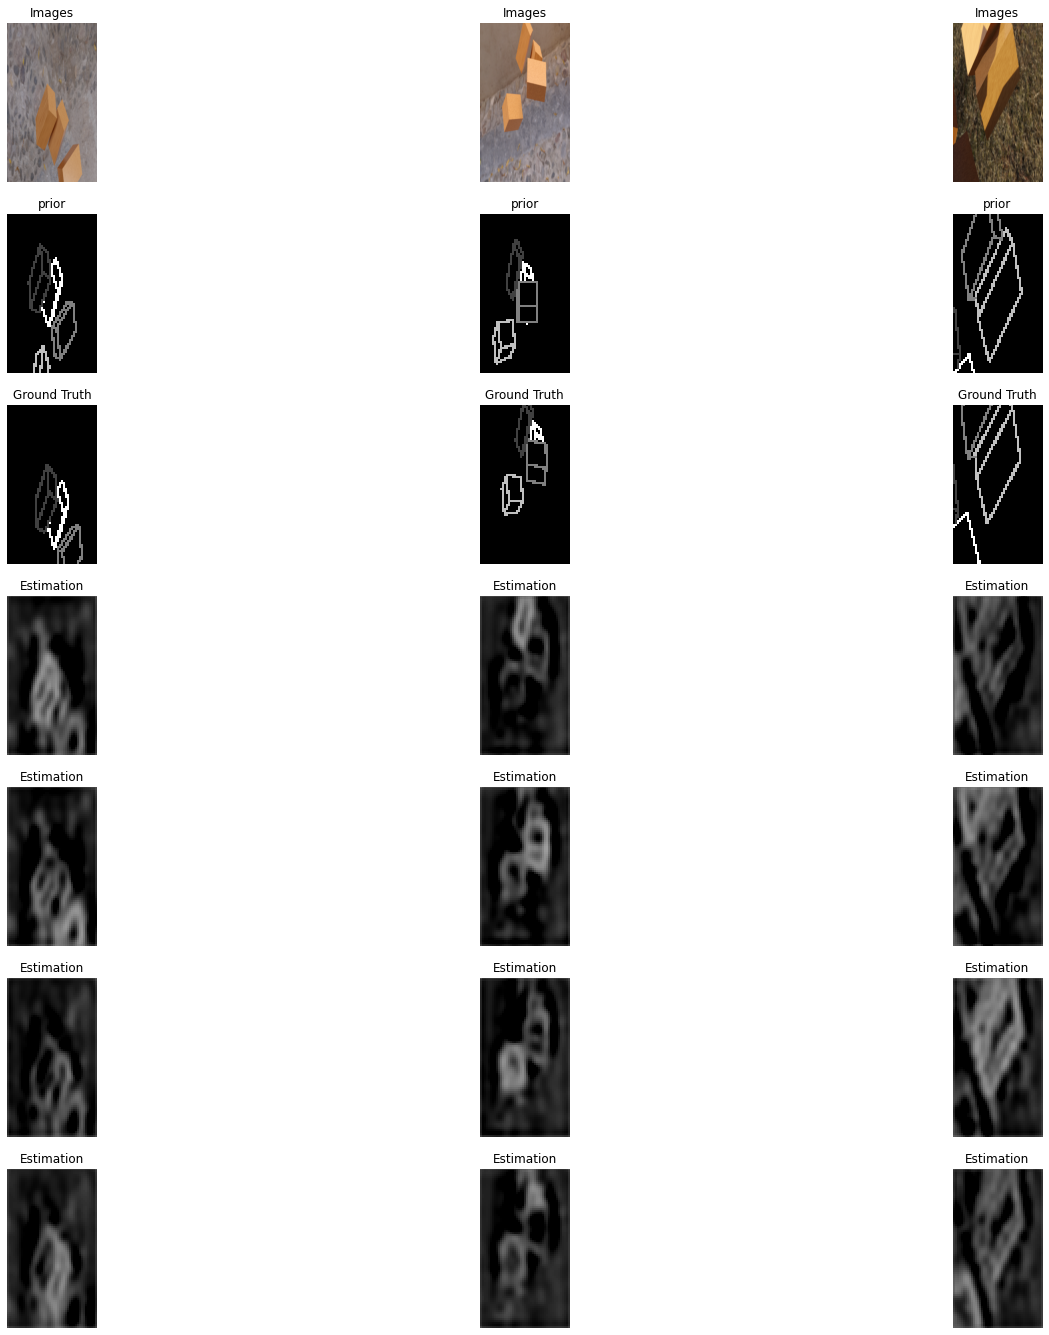

In [50]:
bs = 3
num_graphs = 3 + DP.num_classes
i = 0
for img, label in test_ds.take(1):
    img, label = img, label

    threshold = 0.5

    predictions = model.predict(img)

    plt.figure(figsize=(3 * 8, 24))
    for i in range(bs):
        plt.subplot(num_graphs, bs, i + 1)
        plt.title("Images")
        plt.imshow(tf.keras.preprocessing.image.array_to_img(img[0][i, :, :, :]))
        plt.axis('off')

        plt.subplot(num_graphs, bs, bs + i + 1)
        plt.title("prior")
        plt.imshow(img[1][i, :, :, 0], cmap='gray', vmin=0, vmax=4)
        plt.axis('off')

        plt.subplot(num_graphs, bs, 2 * bs + i + 1)
        plt.title("Ground Truth")
        plt.imshow(label[i, :, :, 0], cmap='gray', vmin=0, vmax=4)
        plt.axis('off')

        for j in range(DP.num_classes):
            plt.subplot(num_graphs, bs, (3 + j) * bs + i + 1)
            plt.title("Estimation")
            plt.imshow(predictions[0][i, :, :, j], cmap='gray', vmin=-5, vmax=5)
            plt.axis('off')

2022-10-31 13:26:45.817619: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


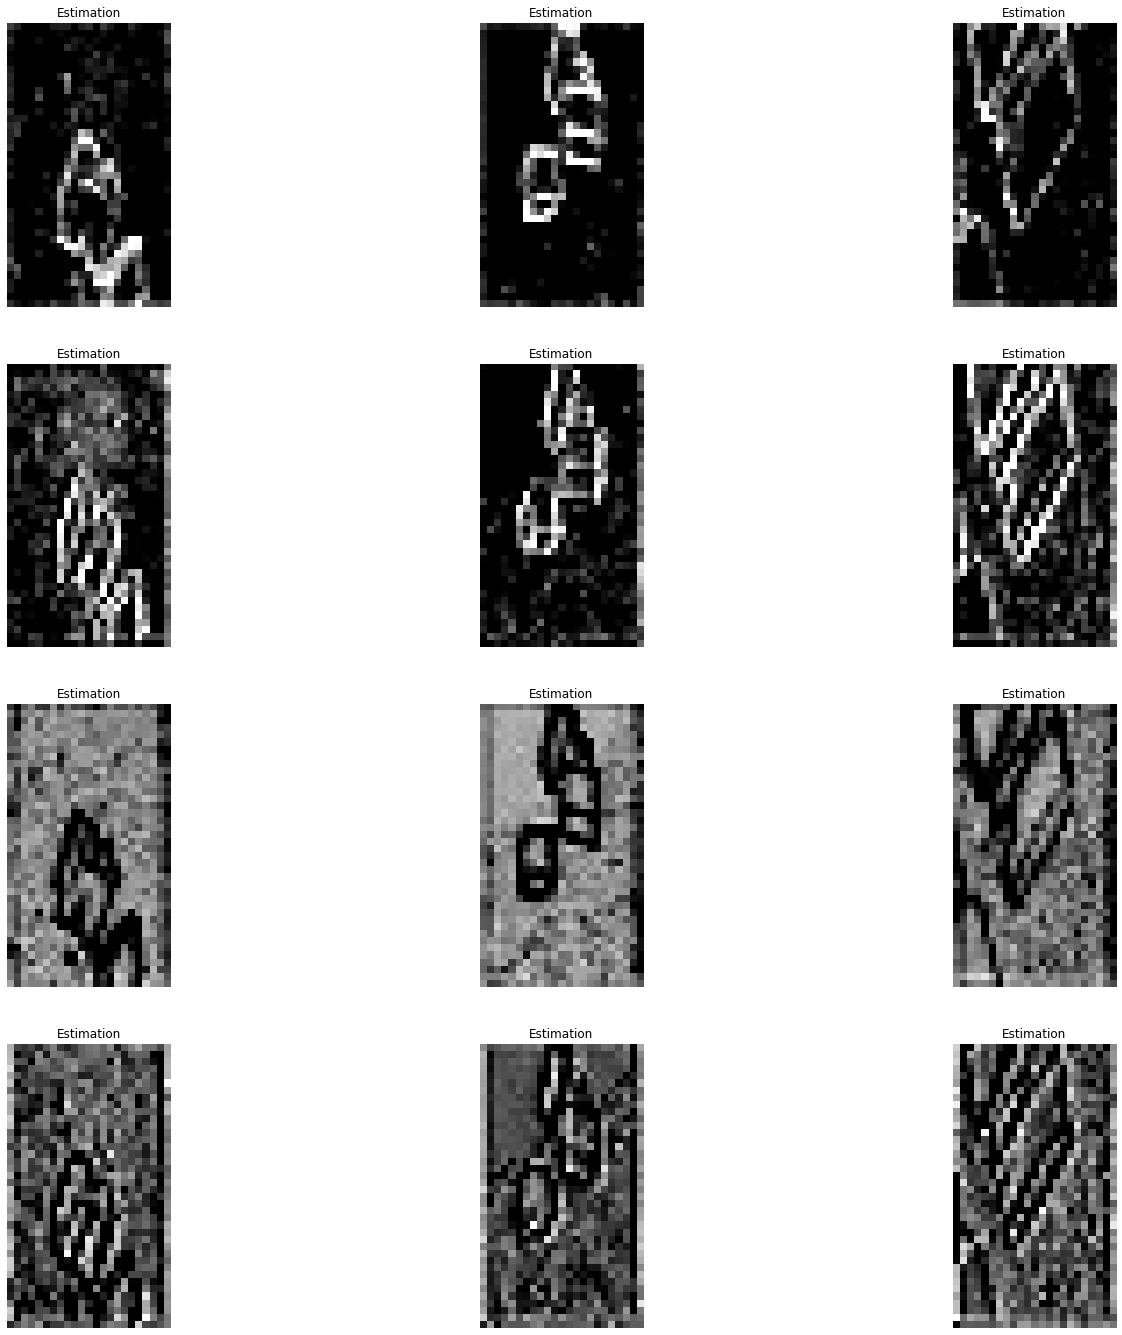

In [31]:
for img, label in test_ds.take(1):
    img, label = img, label

    threshold = 0.5

    predictions = model.predict(img)

    plt.figure(figsize=(3 * 8, 24))
    for i in range(bs):
        for j in range(4):
            plt.subplot(num_graphs, bs, j * bs + i + 1)
            plt.title("Estimation")
            plt.imshow(predictions[1][i, :, :, j], cmap='gray', vmin=0, vmax=2)
            plt.axis('off')

2022-10-31 13:31:06.013809: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


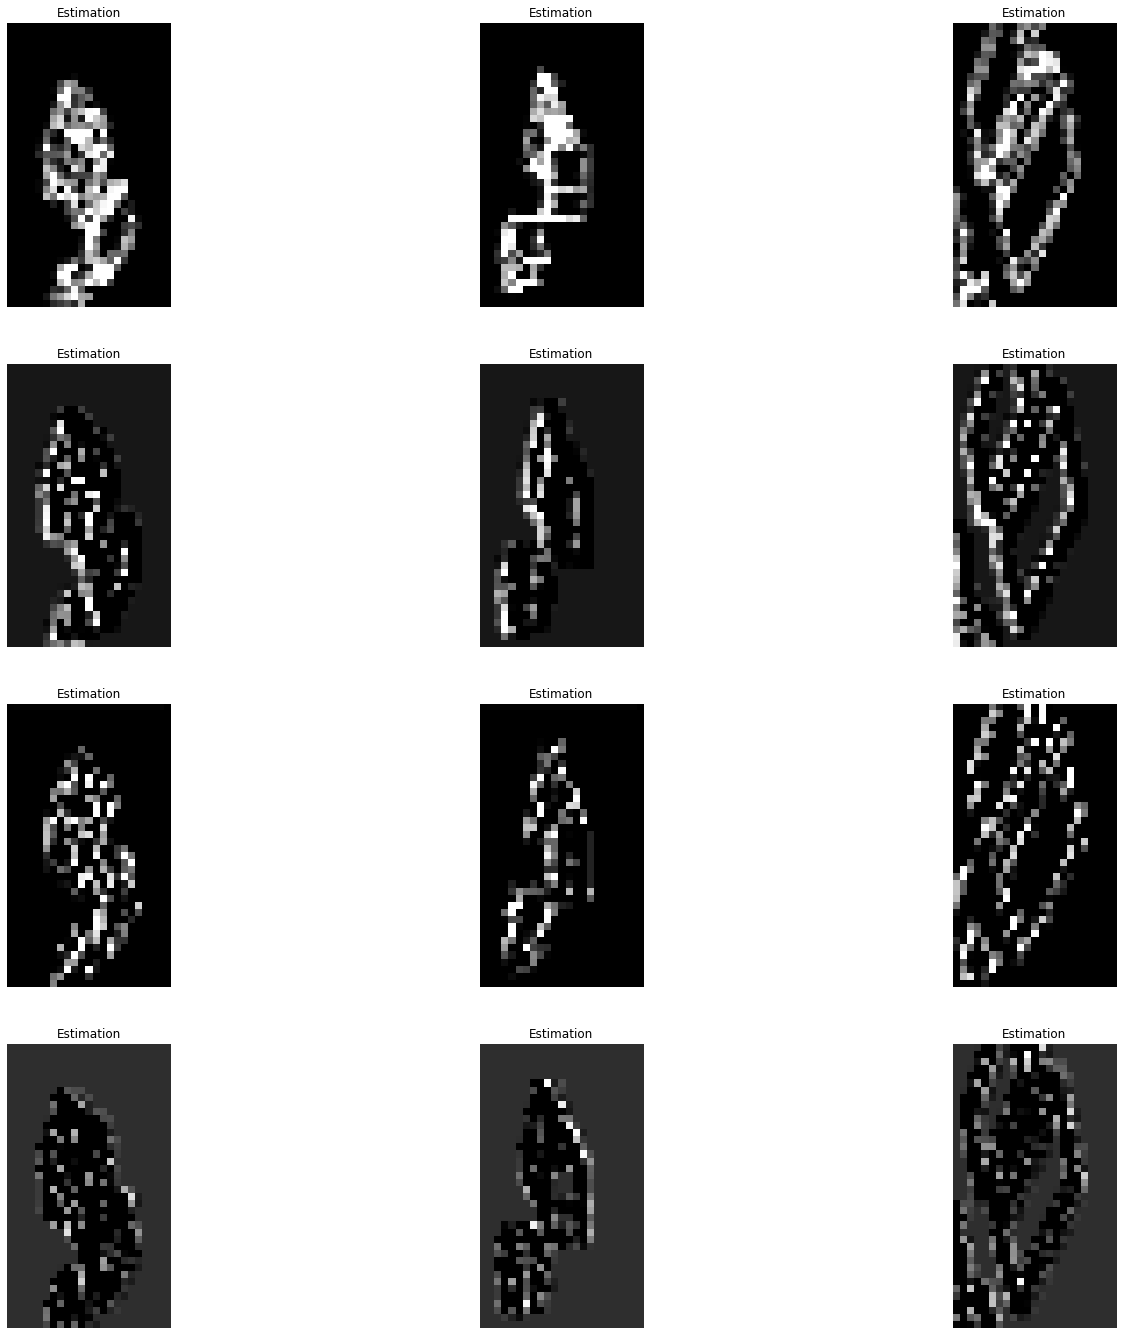

In [33]:
for img, label in test_ds.take(1):
    img, label = img, label

predictions = model.predict(img)

plt.figure(figsize=(3 * 8, 24))
for i in range(bs):
    for j in range(9):
        plt.subplot(num_graphs, bs, j * bs + i + 1)
        plt.title("Estimation")
        plt.imshow(predictions[2][i, :, :, j], cmap='gray', vmin=0, vmax=2)
        plt.axis('off')

# Fine Tuning

# Evaluate on Test DS of Real Images

## Metrics Evaluation

## Visual Results

# Save Model

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss={"output": loss},
              metrics={"output": [metrics.BinaryAccuracyEdges(threshold_prediction=0),
               metrics.F1Edges(threshold_prediction=0, threshold_edge_width=0)]})

if model_cfg["SAVE"]:
    model.save(MF.paths["MODEL"])

    custom_objects = {"BinaryAccuracyEdges": metrics.BinaryAccuracyEdges, "F1Edges": metrics.F1Edges,
                      "<lambda>": loss}

    model = tf.keras.models.load_model(MF.paths["MODEL"], custom_objects=custom_objects)